# Testdata preparation for LSTM and GRU models
This file also prepares a list of test audio for kaggle submission.

In [1]:
from tensorflow import keras
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


import csv
import librosa
import librosa.display
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

train_dir = os.path.abspath('../data/train/train')

classes = os.listdir(train_dir + '/audio')
classes.remove("_background_noise_")

with open(train_dir + '/validation_list.txt') as val_list:
    validation_list = [row[0] for row in csv.reader(val_list)]
assert len(validation_list) == 6798, "Validation files not loaded"

with open(train_dir + "/testing_list.txt") as test_list:
    testing_list = [row[0] for row in csv.reader(test_list)]
assert len(testing_list) == 6835, "testing files not loaded"

In [15]:
training_list  = []
all_files_list = []
class_counts = {}

for folder in classes:
    files = os.listdir(train_dir + '/audio/' + folder)
    for i, f in enumerate(files):
        all_files_list.append(folder+"/"+f)
        path = folder+'/'+f
        if path not in validation_list and path not in testing_list:
            training_list .append(folder+'/'+f)
        class_counts[folder] = i

#remove filenames from validation_list that don't exist anymore (due to eda)
validation_list = list(set(validation_list).intersection(all_files_list))
testing_list = list(set(testing_list).intersection(all_files_list))

assert len(validation_list) + len(testing_list) + len(training_list) == len(all_files_list), "Not All files splitted"
training_list

['bed/00176480_nohash_0.wav',
 'bed/004ae714_nohash_0.wav',
 'bed/004ae714_nohash_1.wav',
 'bed/00f0204f_nohash_0.wav',
 'bed/00f0204f_nohash_1.wav',
 'bed/012c8314_nohash_0.wav',
 'bed/012c8314_nohash_1.wav',
 'bed/0132a06d_nohash_0.wav',
 'bed/0135f3f2_nohash_0.wav',
 'bed/0137b3f4_nohash_0.wav',
 'bed/014f9f65_nohash_0.wav',
 'bed/01648c51_nohash_0.wav',
 'bed/01648c51_nohash_1.wav',
 'bed/016e2c6d_nohash_0.wav',
 'bed/01b4757a_nohash_0.wav',
 'bed/01b4757a_nohash_1.wav',
 'bed/01bcfc0c_nohash_0.wav',
 'bed/0227998e_nohash_0.wav',
 'bed/02746d24_nohash_0.wav',
 'bed/035de8fe_nohash_0.wav',
 'bed/0362539c_nohash_0.wav',
 'bed/0362539c_nohash_1.wav',
 'bed/037c445a_nohash_0.wav',
 'bed/0397ecda_nohash_0.wav',
 'bed/03c96658_nohash_0.wav',
 'bed/042186b8_nohash_0.wav',
 'bed/042ea76c_nohash_0.wav',
 'bed/0447d7c1_nohash_0.wav',
 'bed/0474c92a_nohash_0.wav',
 'bed/0474c92a_nohash_1.wav',
 'bed/05739450_nohash_0.wav',
 'bed/05b2db80_nohash_0.wav',
 'bed/05d18852_nohash_0.wav',
 'bed/0607

004ae714_nohash_0.wav


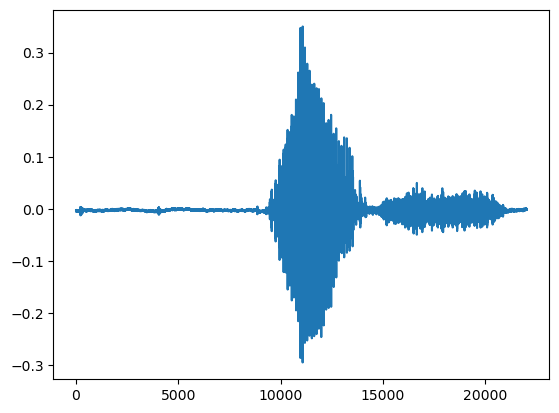

In [4]:
from IPython.display import Audio

sample_audio_file = os.listdir(train_dir+"/audio/yes")[0]
print(sample_audio_file)

x, r = librosa.load(train_dir+"/audio/yes/{}".format(sample_audio_file))
plt.plot(x)

Audio(x, rate=r)

In [2]:
def make_spec(file, file_dir=train_dir, flip=False, ps=False, st = 4):
    """
    create a melspectrogram from the amplitude of the sound
    
    Args:
        file (str): filename
        file_dir (str): directory path
        flip (bool): reverse time axis
        ps (bool): pitch shift
        st (int): half-note steps for pitch shift
    Returns:
        np.array with shape (122,85) (time, freq)
    """
    
    sig, sr = librosa.load(file_dir+file, sr=16000)
    
    if len(sig) < 16000: #pad shorter than 1 sec audio with ramp to zero
        sig = np.pad(sig, (0,16000-len(sig)), "linear_ramp")
        
    if ps:
        sig = librosa.effects.pitch_shift(sig, rate, st)
        
    D = librosa.amplitude_to_db(librosa.stft(sig[:16000], 
                                             n_fft=512, 
                                             hop_length=128,
                                             center=False),
                               ref=np.max)
    S = librosa.feature.melspectrogram(S=D, n_mels=85).T
    
    if flip:
        S = np.flipud(S)
    
    return S.astype(np.float32)

C:\Users\megav\AppData\Local\Temp\ipykernel_22840\173520894.py:23: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(sig[:16000],
C:\Users\megav\AppData\Local\Temp\ipykernel_22840\173520894.py:23: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(sig[:16000],


(122, 85)

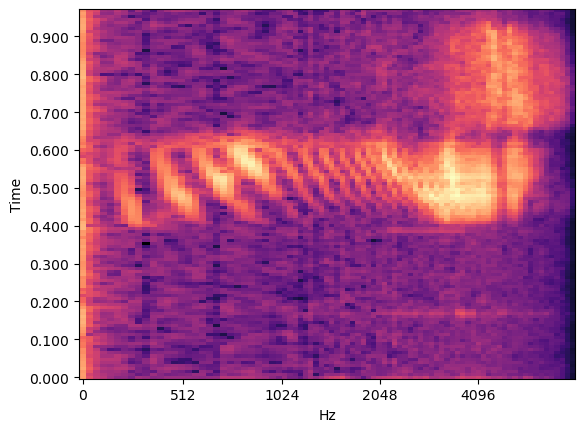

In [5]:
librosa.display.specshow(make_spec("/audio/yes/{}".format(sample_audio_file)),
                         x_axis="mel",
                         fmax=8000,
                         y_axis="time",
                         sr=16000,
                         hop_length=128)
make_spec("/audio/yes/{}".format(sample_audio_file)).shape

In [20]:
def create_sets(file_list=training_list):
    X_array = np.zeros([len(file_list), 122, 85])
    y_array = np.zeros([len(file_list)])
    for ind, file in enumerate(file_list):
        if ind%2000 == 0:
            print("{} done!".format(ind))
        try:
            X_array[ind] = make_spec('/audio/'+file)
        except ValueError:
            print(ind, file, ValueError)
        y_array[ind] = classes.index(file.rsplit('/')[0])
    print("All Done!")
    return X_array, y_array

In [21]:
X_train, y_train = create_sets()

0 done!


C:\Users\megav\AppData\Local\Temp\ipykernel_23512\173520894.py:23: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(sig[:16000],


2000 done!
4000 done!
6000 done!
8000 done!
10000 done!
12000 done!
14000 done!
16000 done!
18000 done!
20000 done!
22000 done!
24000 done!
26000 done!
28000 done!
30000 done!
32000 done!
34000 done!
36000 done!
38000 done!
40000 done!
42000 done!
44000 done!
46000 done!
48000 done!
50000 done!
All Done!


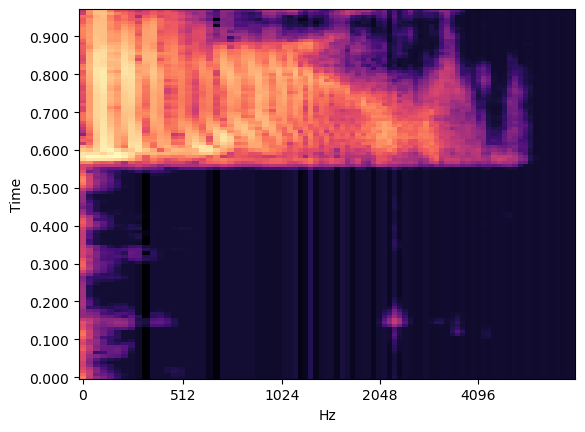

In [25]:
librosa.display.specshow(X_train[6500],
                         x_axis="mel",
                         fmax=8000,
                         y_axis="time",
                         sr=16000,
                         hop_length=128)

In [26]:
print('min: ',np.min(X_train), 
      '\nmax: ', np.max(X_train), 
      '\nmean: ', np.mean(X_train),
      '\nmedian: ', np.median(X_train),
      '\nvariance: ', np.var(X_train))

min:  -2.0306179523468018 
max:  9.682740653715882e-08 
mean:  -1.3122825561691194 
median:  -1.3617993593215942 
variance:  0.1944788539825797


(array([ 1095807.,   126049.,  2893691.,  6657907., 72956893., 20022528.,
        14780289., 14800237., 14142636., 14409737., 14859658., 15323729.,
        15790971., 16155420., 16438746., 16619249., 16694564., 16667003.,
        16507592., 16220361., 15786469., 15230302., 14576597., 13859640.,
        13107864., 12336669., 11567234., 10803237., 10067655.,  9358564.,
         8677803.,  8025373.,  7411213.,  6840600.,  6302918.,  5810461.,
         5349393.,  4918418.,  4506517.,  4097324.,  3677910.,  3250997.,
         2798856.,  2343288.,  1894332.,  1475249.,  1118763.,   750590.,
          460007.,   215250.]),
 array([-2.03061795e+00, -1.99000559e+00, -1.94939323e+00, -1.90878087e+00,
        -1.86816851e+00, -1.82755615e+00, -1.78694379e+00, -1.74633143e+00,
        -1.70571906e+00, -1.66510670e+00, -1.62449434e+00, -1.58388198e+00,
        -1.54326962e+00, -1.50265726e+00, -1.46204490e+00, -1.42143254e+00,
        -1.38082018e+00, -1.34020782e+00, -1.29959545e+00, -1.25898309e+

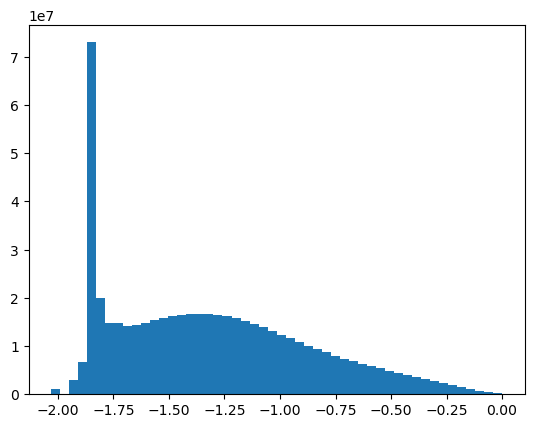

In [27]:
plt.hist(X_train.flatten(), bins=50)

In [28]:
np.save(train_dir + "/X_train.npy", np.expand_dims(X_train, -1)+1.3) #Normalizing using mean
np.save(train_dir + "/y_train.npy", y_train.astype(np.int64))
print("Saved!")

Saved!


In [29]:
X_val, y_val = create_sets(file_list=validation_list)

0 done!


C:\Users\megav\AppData\Local\Temp\ipykernel_23512\173520894.py:23: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(sig[:16000],


2000 done!
4000 done!
6000 done!
All Done!


(array([  154936.,    18034.,   411637.,   957639., 10308869.,  2858920.,
         2146576.,  2155729.,  2049896.,  2059560.,  2087877.,  2115104.,
         2131919.,  2143087.,  2147197.,  2145451.,  2141074.,  2122131.,
         2092730.,  2052251.,  2000020.,  1935891.,  1858177.,  1773383.,
         1676591.,  1574027.,  1469420.,  1364515.,  1269358.,  1171726.,
         1082043.,  1002713.,   927025.,   860903.,   796600.,   733194.,
          678026.,   623982.,   568354.,   518708.,   468357.,   415581.,
          360690.,   301772.,   244876.,   191338.,   142733.,    97326.,
           61307.,    26007.]),
 array([-2.03061795e+00, -1.99000559e+00, -1.94939323e+00, -1.90878087e+00,
        -1.86816851e+00, -1.82755615e+00, -1.78694379e+00, -1.74633143e+00,
        -1.70571906e+00, -1.66510670e+00, -1.62449434e+00, -1.58388198e+00,
        -1.54326962e+00, -1.50265726e+00, -1.46204490e+00, -1.42143254e+00,
        -1.38082018e+00, -1.34020782e+00, -1.29959546e+00, -1.25898309e+

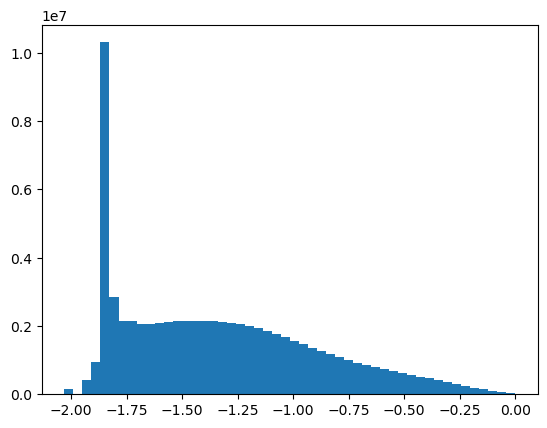

In [30]:
plt.hist(X_val.flatten(), bins=50)

In [31]:
np.save(train_dir + "/X_val.npy", np.expand_dims(X_val, -1)+1.3) #Normalizing using mean
np.save(train_dir + "/y_val.npy", y_val.astype(np.int64))
print("Saved!")

Saved!


In [3]:
train_dir = os.path.abspath('../data/train/train')

X_train = np.load(train_dir + "/X_train.npy")
y_train = np.load(train_dir + "/y_train.npy")

X_val = np.load(train_dir + "/X_val.npy")
y_val = np.load(train_dir + "/y_val.npy")

In [5]:
X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((-1, X_val.shape[1], X_val.shape[2]))

In [6]:
classes = os.listdir(train_dir+'/audio')
print(classes)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero', '_background_noise_']


In [7]:
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return {cls: float(majority/count) for cls, count in counter.items()}

class_weights = get_class_weights(y_train)
class_weights

{0: 1.4119402985074627,
 1: 1.3408929836995038,
 2: 1.3523945675482487,
 3: 1.3553008595988538,
 4: 1.0271444082519001,
 5: 1.0215982721382288,
 6: 1.0260303687635575,
 7: 1.0288200108754757,
 8: 1.0166577109081139,
 9: 1.3780043699927167,
 10: 1.3258584442887176,
 11: 1.0288200108754757,
 12: 1.3286516853932584,
 13: 1.0090666666666666,
 14: 1.0210469508904478,
 15: 1.0288200108754757,
 16: 1.0150214592274678,
 17: 1.0,
 18: 1.0215982721382288,
 19: 1.0090666666666666,
 20: 1.379008746355685,
 21: 1.0155662909286098,
 22: 1.0037135278514588,
 23: 1.0277023356871267,
 24: 1.3770014556040757,
 25: 1.010144153764015,
 26: 1.026587086272382,
 27: 1.338048090523338,
 28: 1.0172043010752687,
 29: 1.0139335476956055}

In [8]:
def convert_list_dict(lst):
    res_dct = {i: val for i, val in enumerate(lst)}
    return res_dct
         
classes_index = convert_list_dict(classes)
classes_index

{0: 'bed',
 1: 'bird',
 2: 'cat',
 3: 'dog',
 4: 'down',
 5: 'eight',
 6: 'five',
 7: 'four',
 8: 'go',
 9: 'happy',
 10: 'house',
 11: 'left',
 12: 'marvin',
 13: 'nine',
 14: 'no',
 15: 'off',
 16: 'on',
 17: 'one',
 18: 'right',
 19: 'seven',
 20: 'sheila',
 21: 'six',
 22: 'stop',
 23: 'three',
 24: 'tree',
 25: 'two',
 26: 'up',
 27: 'wow',
 28: 'yes',
 29: 'zero',
 30: '_background_noise_'}

In [10]:
NB_CLASSES = len(classes)
NB_CLASSES

31

In [40]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=NB_CLASSES)
y_val = to_categorical(y_val, num_classes=NB_CLASSES)

Prepare test folder

In [23]:
test_dir = os.path.abspath('../data/test/test/')
files = os.listdir(test_dir + '/audio')
X_test = np.zeros([len(files), 122, 85])
files_test = []
for i, f in enumerate(files):
    # files
    if i%2000 == 0:
        print("{} done!".format(i))
    try:
        files_test.append(f)
        X_test[i] = make_spec('/audio/'+f, file_dir=test_dir)
    except ValueError:
        print(i, f, ValueError)

print(X_test.shape)
len(files_test)

np.save(test_dir + "/X_test.npy", X_test)
np.savetxt(test_dir + "/X_files.txt", files_test, delimiter=" ", newline = "\n", fmt="%s")
print("Saved!")

Saved!
